In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import math
import random
import numpy as np    
from sklearn.ensemble import GradientBoostingClassifier

### Exploratory Data Analysis

In [2]:
# df_loaded = pd.read_csv("data/training_set_VU_DM.csv")
df_loaded = pickle.load(open("pickles/df_small_train.pkl", "rb"))
display(df_loaded.describe())

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
count,49335.000000,49335.000000,49335.000000,2061.000000,2105.000000,49335.000000,49335.000000,49335.000000,49255.000000,49335.000000,...,1100.000000,3742.000000,4209.000000,1705.000000,18315.000000,18895.000000,5785.000000,49335.000000,1365.000000,49335.000000
mean,164188.521577,10.128975,175.190372,3.427952,195.600418,173.419479,70233.165501,3.172150,3.787768,0.634053,...,17.168182,0.167557,0.089808,21.055718,-0.061807,0.009844,14.729646,0.044532,377.469392,0.027668
std,94670.449020,7.738712,66.350922,0.615106,103.703116,68.706884,40668.580445,1.064249,1.042209,0.481700,...,29.084044,0.592644,0.315947,52.523009,0.471767,0.194963,15.867684,0.206277,507.073012,0.164021
min,124.000000,1.000000,4.000000,2.000000,39.770000,2.000000,1.000000,0.000000,0.000000,0.000000,...,2.000000,-1.000000,-1.000000,2.000000,-1.000000,-1.000000,2.000000,0.000000,0.000000,0.000000
25%,85522.000000,5.000000,100.000000,2.960000,115.320000,100.000000,35122.000000,3.000000,3.500000,0.000000,...,5.000000,0.000000,0.000000,7.000000,0.000000,0.000000,7.000000,0.000000,120.560000,0.000000
50%,163166.000000,5.000000,219.000000,3.500000,165.270000,219.000000,70065.000000,3.000000,4.000000,1.000000,...,11.000000,0.000000,0.000000,12.000000,0.000000,0.000000,11.000000,0.000000,218.680000,0.000000
75%,242490.000000,15.000000,219.000000,3.890000,249.680000,219.000000,105183.000000,4.000000,4.500000,1.000000,...,18.000000,1.000000,0.000000,21.000000,0.000000,0.000000,17.000000,0.000000,433.450000,0.000000
max,332740.000000,34.000000,229.000000,5.000000,560.060000,230.000000,140816.000000,5.000000,5.000000,1.000000,...,456.000000,1.000000,1.000000,1074.000000,1.000000,1.000000,525.000000,1.000000,4902.040000,1.000000


In [42]:
# temporally store
df = df_loaded
df.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,month,combine_inv_rate1,combine_inv_rate2,combine_inv_rate3,combine_inv_rate4,combine_inv_rate5,combine_inv_rate6,combine_inv_rate7,combine_inv_rate8,competitor_bool
1196703,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,2990,3,4.5,...,1,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0
1196704,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,4256,4,4.5,...,1,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0
1196705,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,6427,4,4.0,...,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0
1196706,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,8289,4,4.5,...,1,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0
1196707,79994,2013-01-03 13:23:33,29,132,NaN,NaN,219,13668,4,4.0,...,1,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0


### In this dataset we count 129.113 unique hotels

In [4]:
# Change time information to year and month columns
df["date_time"] = pd.to_datetime(df["date_time"])
df["year"] = df["date_time"].dt.year
df["month"] = df["date_time"].dt.month

## Analyse comp_rate_diff --> difference in price for Expedia competitor and difference in availability

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


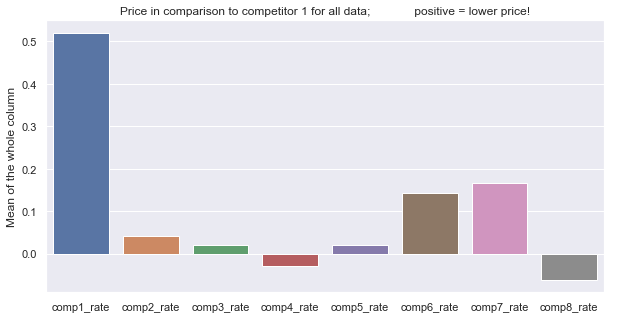

In [5]:
import seaborn as sns
sns.set()

compare_cols = ["comp1_rate", "comp2_rate", "comp3_rate", "comp4_rate", "comp5_rate",
                "comp6_rate", "comp7_rate", "comp8_rate"]

total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols]

def showcompareplot(compare_cols, total_diff, title):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set(ylabel='Mean of the whole column', title=title)
    sns.barplot(compare_cols, total_diff)

showcompareplot(compare_cols, total_diff, title="Price in comparison to competitor 1 for all data; \
            positive = lower price!")

### On average, Expedia has a lower price than competitor 1 for the hotel. For competitor 4, Expedia has a higher price (on average!). However, when we look at availability we see that for competitor 4, the availability is slightly higher than other competitors. On the other hand, this is only about 10%. 

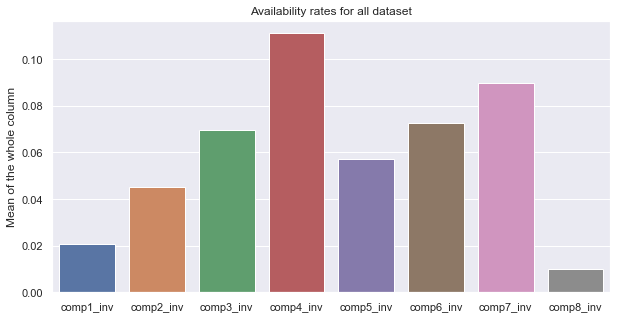

In [6]:
compare_cols_inv = ["comp1_inv", "comp2_inv", "comp3_inv", "comp4_inv", "comp5_inv",
                "comp6_inv", "comp7_inv", "comp8_inv"]

total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols_inv]
    
showcompareplot(compare_cols_inv, total_diff, "Availability rates for all dataset")

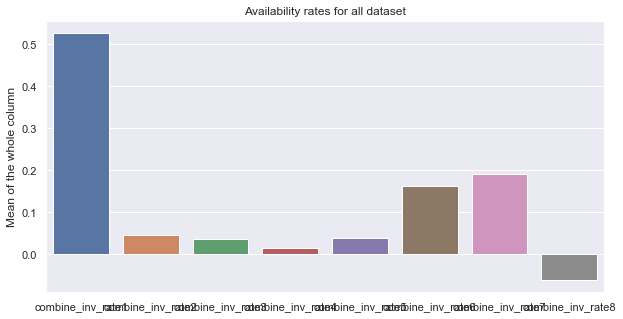

In [7]:
# Add comp_inv and comp_rate together 
for i in range (len(compare_cols)):
    df["combine_inv_rate" + str(i + 1)] = df[compare_cols_inv[i]] + df[compare_cols[i]]

compare_cols_total = ["combine_inv_rate1", "combine_inv_rate2", "combine_inv_rate3", "combine_inv_rate4",
                      "combine_inv_rate5", "combine_inv_rate6", "combine_inv_rate7", "combine_inv_rate8"]
total_diff = []
[total_diff.append(np.mean(df[col])) for col in compare_cols_total]
    
showcompareplot(compare_cols_total, total_diff, "Availability rates for all dataset")

In [8]:
# Make a new column for when there exists a competitor
competitor_bools = []

for index, row in df.iterrows():
    comp_bool = 0
    
    # compare_cols_total exists of a column of data from comp_rate and comp_inv,
    # so, a combination of competitor price and room-availability. 
    for competitor in compare_cols_total:
        if row[competitor] == 1:
            comp_bool = 1
    competitor_bools.append(comp_bool)
df["competitor_bool"] = competitor_bools

Text(0.5, 1.0, 'Existence of a competitor; 0 = False, 1 = True')

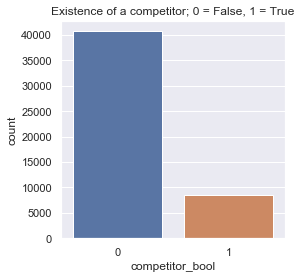

In [9]:
plt.figure(figsize=(4, 4))
sns.countplot(x="competitor_bool", data=df).set_title("Existence of a competitor; 0 = False, 1 = True")

In [10]:
# Drop all other comp_rate and comp_inv columns:
df = df.drop(compare_cols_inv, axis=1)
df = df.drop(compare_cols, axis=1)
df = df.drop(compare_cols_total, axis=1)

### Most people search for a one night stay and with two people (adults) and no children. 

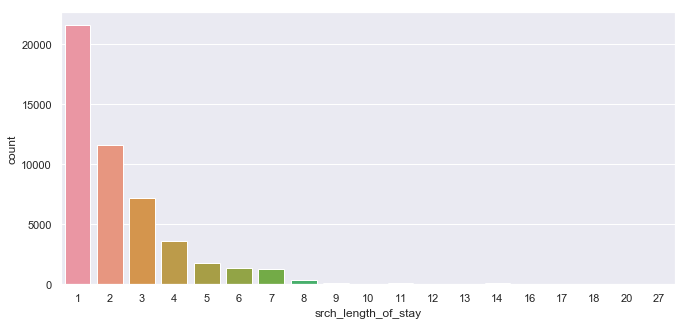

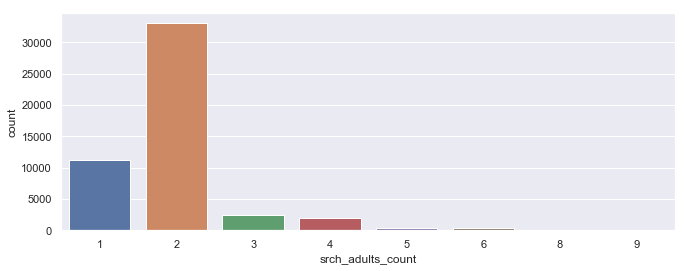

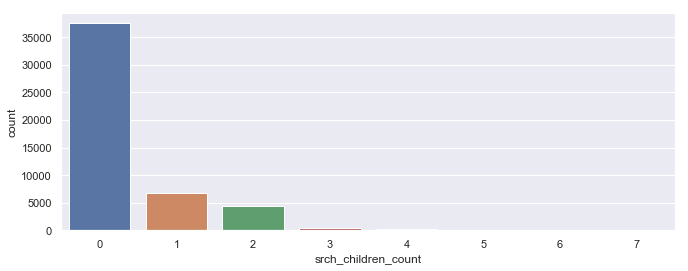

In [11]:
plt.figure(figsize=(11, 5))
sns.countplot(x="srch_length_of_stay", data=df)

plt.figure(figsize=(11, 4))
sns.countplot(x="srch_adults_count", data=df)

plt.figure(figsize=(11, 4))
sns.countplot(x="srch_children_count", data=df)

### Most people visit the website from the US (id = 219).

[219, 100, 55, 216, 220]


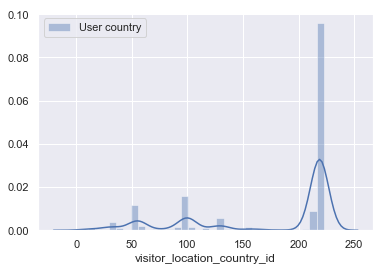

In [12]:
# Get five most frequent countries 
print(df['visitor_location_country_id'].value_counts()[:5].index.tolist())
sns.distplot(df['visitor_location_country_id'], label="User country")
plt.legend()

## Clean price data

#### There are a lot of prices between 7 and 240, then outlying category between 240 and 554655:
#### Categories (7, interval[float64]): [(6.0889999999999995, 69.0] < (69.0, 90.0] < (90.0, 110.0] < (110.0, 136.0] < (136.0, 170.077] < (170.077, 239.0] < (239.0, 554655.0]]

## Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay

## For this reason, the choice was made to only select the US 

In [13]:
df_us = df.loc[df['visitor_location_country_id'] == 219].copy()

### There are a lot less clicks for the hotels with higher price (as expected)

In [14]:
# Correct for number of nights
df_us["price_correction"] = df_us["price_usd"] / df_us["srch_length_of_stay"]

df_us.groupby('click_bool')['price_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
click_bool,,,,,,,,
0,27454.0,308.040788,5721.827452,13.0,81.0,116.0,171.0,418446.0
1,1221.0,227.268182,3210.130045,23.0,84.0,112.0,159.0,112266.0


In [ ]:
df_us['PriceBand'] = pd.qcut(df_us["price_correction"], 7)
df_us['PriceBand'].head(10)

In [15]:
import seaborn as sns
import matplotlib.pylab as plt

plt.clf()
plt.xlim(0, 1000)
sns.distplot(df_us['price_usd'], bins=10000, label="User country")

1050185      (29.5, 46.0]
1050186      (63.0, 83.0]
1050187      (63.0, 83.0]
1050188      (46.0, 63.0]
1050189    (108.5, 150.0]
1050190      (46.0, 63.0]
1050191      (63.0, 83.0]
1050192     (83.0, 108.5]
1050193      (46.0, 63.0]
1050194      (29.5, 46.0]
Name: PriceBand, dtype: category
Categories (7, interval[float64]): [(1.7770000000000001, 29.5] < (29.5, 46.0] < (46.0, 63.0] < (63.0, 83.0] < (83.0, 108.5] < (108.5, 150.0] < (150.0, 418446.0]]

In [16]:
# Categorize into labels
df_us['PriceBand'] = pd.qcut(df_us["price_correction"], 7, labels=[0,1,2,3,4,5,6])

### Add column that tells us whether someone has visited a hotel before

In [50]:
hist_starrating = df.visitor_hist_starrating.isna()
hist_adr = df.visitor_hist_adr_usd.isna()

# Dit kan waarschijnlijk veel mooier en sneller maar het werkt...
total_visited = []
for index, row in df.iterrows():
    if hist_starrating[index] or hist_adr[index]:
        visited = 0
    else:
        visited = 1
    total_visited.append(visited)
    
df["total_visited"] = total_visited

# lookup = df.loc[:, 'visitor_hist_starrating':'visitor_hist_adr_usd'].notnull().idxmax(1)
# df.assign(visited_before=df.lookup(lookup.index, lookup.values))

Text(0.5, 1.0, 'Visited hotel before or not; 0 = False, 1 = True')

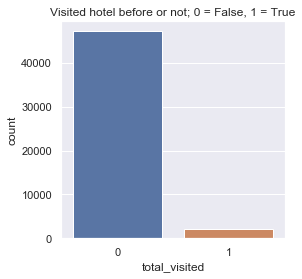

In [51]:
plt.figure(figsize=(4, 4))
sns.countplot(x="total_visited", data=df).set_title("Visited hotel before or not; 0 = False, 1 = True")

In [ ]:
sns.distplot(df['prop_location_score1'], label="prop_location_score")